<a href="https://colab.research.google.com/github/barksdaleaz/big_transfer/blob/master/big_transfer_tf2_amber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Google LLC.



In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BigTransfer (BiT): A step-by-step tutorial for state-of-the-art vision

By Jessica Yung and Joan Puigcerver, altered by Amber Barksdale for use in an assignment for CS-GY6613 (Artificial Intelligence I), NYU Tandon Spring 2021.

In this colab, we will show you how to load one of our BiT models (a ResNet50x3 trained on ImageNet-21k), use it out-of-the-box and fine-tune it on the CIFAR-10 dataset.

This colab accompanies our [TensorFlow blog post](https://ai.googleblog.com/2020/05/open-sourcing-bit-exploring-large-scale.html) and is based on the [BigTransfer paper](https://arxiv.org/abs/1912.11370).

The models from the paper can be found on [TensorFlow Hub](https://tfhub.dev/google/collections/bit/1) and additional models obtained by finetuning BiT-m in more specific sets of data can be found [here](https://tfhub.dev/google/collections/experts/bit/1).
We also share code to fine-tune our models in TensorFlow2, JAX and PyTorch in [our GitHub repository](https://github.com/google-research/big_transfer).


In [2]:
#@title Imports
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime
import io
import itertools
from packaging import version

from tensorflow import keras

import sklearn.metrics

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.4.1


In [3]:
#@title Construct imagenet logit-to-class-name dictionary (imagenet_int_to_str)

!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

--2021-03-11 22:35:34--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 64.233.167.128, 74.125.71.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2021-03-11 22:35:34 (90.0 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



In [4]:
#@title CIFAR-10 Label Names
cifar_10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the pre-trained BiT model

First, we will load a pre-trained BiT model. There are ten models you can choose from, spanning two upstream training datasets and five ResNet architectures.

In this tutorial, we will use a ResNet50x3 model trained on ImageNet-21k.

### Where to find the models

Models that output image features (pre-logit layer) can be found at
* `https://tfhub.dev/google/bit/m-{archi, e.g. r50x1}/1`

whereas models that return outputs in the Imagenet  (ILSVRC-2012) label space can be found at 

* `https://tfhub.dev/google/bit/m-{archi, e.g. r50x1}/ilsvrc2012_classification/1`

The architectures we have include R50x1, R50x3, R101x1, R101x3 and R152x4. The architectures are all in lowercase in the links.

So for example, if you want image features from a ResNet-50, you could use the model at `https://tfhub.dev/google/bit/m-r50x1/1`. This is also the model  we'll use in this tutorial.

In [5]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x3/1"
module = hub.KerasLayer(model_url)

## Use BiT out-of-the-box

If you don’t yet have labels for your images (or just want to have some fun), you may be interested in using the model out-of-the-box, i.e. without fine-tuning it. For this, we will use a model fine-tuned on ImageNet so it has the interpretable ImageNet label space of 1k classes. Many common objects are not covered, but it gives a reasonable idea of what is in the image. 

In [6]:
# Load model fine-tuned on ImageNet
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

Using the model is very simple:
```
logits = module(image)
```

Note that the BiT models take inputs of shape [?, ?, 3] (i.e. 3 colour channels) with values between 0 and 1.

In [7]:
#@title Helper functions for loading image (hidden)

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [8]:
#@title Plotting helper functions (hidden)
#@markdown Credits to Xiaohua Zhai, Lucas Beyer and Alex Kolesnikov from Brain Zurich, Google Research

# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

def show_preds(logits, image, correct_cifar_label=None, cifar_logits=False):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_cifar_label is not None:
    ax1.set_title(cifar_10_labels[correct_cifar_label])
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    if not cifar_logits:
      # predicting in imagenet label space
      classes.append(imagenet_int_to_str[j])
    else:
      # predicting in tf_flowers label space
      classes.append(cifar_10_labels[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

**TODO: try replacing the URL below with a link to an image of your choice!**

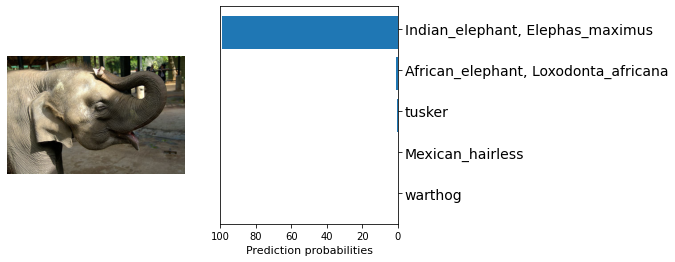

In [9]:
# Load image (image provided is CC0 licensed)
img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image = load_image_from_url(img_url)

# Run model on image
logits = imagenet_module(image)

# Show image and predictions
show_preds(logits, image[0])

Here the model correctly classifies the photo as an elephant. It is likely an Asian elephant because of the size of its ears.

We will also try predicting on an image from the dataset we're going to fine-tune on - [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), which has also been used in [other tutorials](https://www.tensorflow.org/tutorials/load_data/images). This dataset contains 60,000 images of 10 classes.

Note that the correct label of the image we're going to predict on is not a class in ImageNet and so the model cannot predict that at the moment - let’s see what it tries to do instead.

In [10]:
# Import CIFAR-10 data from tfds

# dataset_name = 'CIFAR-10'
# ds, info = tfds.load(name=dataset_name, split=['train'], with_info=True)
# using below to load entire data set for test purposes. for some reason i can't
# get the large data set with the bottom portion
ds, info2 = tfds.load(
    name='cifar10',
    split='train',
    with_info=True,
)

# using below to load only 100 images
train_10_20_ds, info = tfds.load(
    name='cifar10', 
    split='train[10:20]',
    with_info=True
    )
# ds = ds[0] <- this threw an error so... i just got rid of it? lol idk what it is for
# print(train_10_20_ds)
num_examples = info.splits['train[10:110]'].num_examples
print(num_examples)
num_examples2 = info2.splits['train'].num_examples
NUM_CLASSES = 10
print(num_examples2)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteXHYXWX/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteXHYXWX/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
100
50000


In [11]:
#@title Alternative code for loading a dataset
#@markdown We provide alternative code for loading `tf_flowers` from an URL in this cell to make it easy for you to try loading your own datasets. 

#@markdown This code is commented out by default and replaces the cell immediately above. Note that using this option may result in a different example image below.
"""
data_dir = tf.keras.utils.get_file(origin='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                                         fname='CIFAR-10', untar=True)
data_dir = pathlib.Path(data_dir)

IMG_HEIGHT = 224
IMG_WIDTH = 224

CLASS_NAMES = cifar_10_labels  # from plotting helper functions above
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(data_dir.glob('*/*.jpg')))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  
  return tf.where(parts[-2] == CLASS_NAMES)[0][0]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  return img  

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  features = {'image': img, 'label': label}
  return features

# list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
list_ds = tf.keras.datasets.cifar10.load_data()
ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
"""

"\ndata_dir = tf.keras.utils.get_file(origin='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',\n                                         fname='CIFAR-10', untar=True)\ndata_dir = pathlib.Path(data_dir)\n\nIMG_HEIGHT = 224\nIMG_WIDTH = 224\n\nCLASS_NAMES = cifar_10_labels  # from plotting helper functions above\nNUM_CLASSES = len(CLASS_NAMES)\nnum_examples = len(list(data_dir.glob('*/*.jpg')))\n\ndef get_label(file_path):\n  # convert the path to a list of path components\n  parts = tf.strings.split(file_path, os.path.sep)\n  # The second to last is the class-directory\n  \n  return tf.where(parts[-2] == CLASS_NAMES)[0][0]\n\ndef decode_img(img):\n  # convert the compressed string to a 3D uint8 tensor\n  img = tf.image.decode_jpeg(img, channels=3)\n  return img  \n\ndef process_path(file_path):\n  label = get_label(file_path)\n  # load the raw data from the file as a string\n  img = tf.io.read_file(file_path)\n  img = decode_img(img)\n  features = {'image': img, 'label': label}

In [20]:
# Split into train and test sets
# We have checked that the classes are reasonably balanced.
train_split = 0.9
num_train = int(train_split * num_examples2)

# Train_10_20_DS_Train should equal 100 images
train_10_20_ds_train = train_10_20_ds.take(100)
ds_test = ds.skip(num_train)
# train_10_20_ds_test = train_10_20_ds.skip(10)

# DATASET_NUM_TRAIN_EXAMPLES = num_examples
DATASET_NUM_TRAIN_EXAMPLES = 100

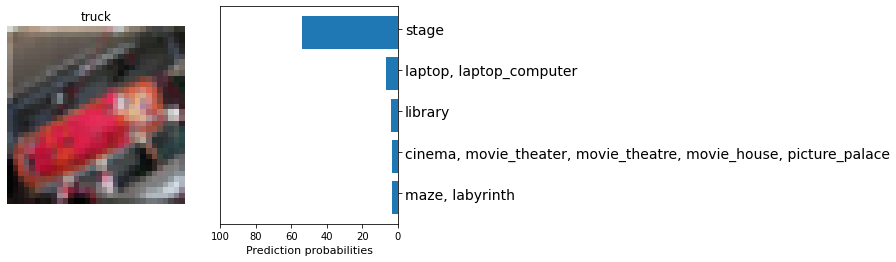

In [19]:
#@title
for features in train_10_20_ds_train.take(1):
  image = features['image']
  image = preprocess_image(image)

  # Run model on image
  logits = imagenet_module(image)
  
  # Show image and predictions
  show_preds(logits, image[0], correct_cifar_label=features['label'].numpy())

In this case, In this case, 'tulip' is not a class in ImageNet, and the model predicts a reasonably similar-looking classe, 'bell pepper'.

## Fine-tuning the BiT model

Now we are going to fine-tune the BiT model so it performs better on a specific dataset. Here we are going to use Keras for simplicity and we are going to fine-tune the model on the CIFAR-10 dataset (`cifar_10`). 

We will use the model we loaded at the start (i.e. the one not fine-tuned on ImageNet) so the model is less biased towards ImageNet-like images.

There are two steps:
1. Create a new model with a new final layer (which we call the ‘head’), and
2. Fine-tune this model using BiT-HyperRule, our hyperparameter heuristic.


### 1. Creating the new model



To create the new model, we:

1. Cut off the BiT model’s original head. This leaves us with the “pre-logits” output.
 - We do not have to do this if we use the ‘feature extractor’ models ((i.e. all those in subdirectories titled `feature_vectors`), since for those models the head has already been cut off.

2. Add a new head with the number of outputs equal to the number of classes of our new task. Note that it is important that we initialise the head to all zeroes.

#### Add new head to the BiT model

Since we want to use BiT on a new dataset (not the one it was trained on), we need to replace the final layer with one that has the correct number of output classes. This final layer is called the head.

Note that it is important to **initialise the new head to all zeros**.

In [14]:
#@title BiT With a new head
# Add new head to the BiT model

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

### Data and preprocessing




#### BiT Hyper-Rule: Our hyperparameter selection heuristic
When we fine-tune the model, we use BiT-HyperRule, our heuristic for choosing hyperparameters for downstream fine-tuning. This is **not a hyperparameter sweep** - given a dataset, it specifies one set of hyperparameters that we’ve seen produce good results. You can often obtain better results by running a more expensive hyperparameter sweep, but BiT-HyperRule is an effective way of getting good initial results on your dataset.

**Hyperparameter heuristic details**

In BiT-HyperRule, we use a vanilla SGD optimiser with an initial learning rate of 0.003, momentum 0.9 and batch size 512. We decay the learning rate by a factor of 10 at 30%, 60% and 90% of the training steps. 

As data preprocessing, we resize the image, take a random crop, and then do a random horizontal flip (details in table below). We do random crops and horizontal flips for all tasks except those where such actions destroy label semantics. E.g. we don’t apply random crops to counting tasks, or random horizontal flip to tasks where we’re meant to predict the orientation of an object.


Image area | Resize to | Take random crop of size
--- | --- | ---
Smaller than 96 x 96 px | 160 x 160 px | 128 x 128 px
At least 96 x 96 px | 512 x 512 px | 480 x 480 px

*Table 1: Downstream resizing and random cropping details. If images are larger, we resize them to a larger fixed size to take advantage of benefits from fine-tuning on higher resolution.*


We also use MixUp for datasets with more than 20k examples. Since the dataset used in this tutorial does not use MixUp, for simplicity and speed, we do not include it in this colab, but include it in our [github repo implementation](https://github.com/google-research/big_transfer).

In [22]:
#@title Set dataset-dependent hyperparameters

#@markdown Here we set dataset-dependent hyperparameters. For example, our dataset of flowers has 3670 images of varying size (a few hundred x a few hundred pixels), so the image size is larger than 96x96 and the dataset size is <20k examples. However, for speed reasons (since this is a tutorial and we are training on a single GPU), we will select the `<96x96 px` option and train on lower resolution images. As we will see, we can still attain strong results.

#@markdown **Algorithm details: how are the hyperparameters dataset-dependent?** 

#@markdown It's quite intuitive - we resize images to a smaller fixed size if they are smaller than 96 x 96px and to a larger fixed size otherwise. The number of steps we fine-tune for is larger for larger datasets. 

IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

**Tip**: if you are running out of memory, decrease the batch size. A way to adjust relevant parameters is to linearly scale the schedule length and learning rate.

```
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
lr = 0.003 * BATCH_SIZE / 512
```

These adjustments have already been coded in the cells below - you only have to change the `BATCH_SIZE`. If you change the batch size, please re-run the cell above as well to make sure the `SCHEDULE_LENGTH` you are starting from is correct as opposed to already altered from a previous run.

In [23]:
#@title Preprocessing Helper Functions
# Preprocessing helper functions

# Create data pipelines for training and testing:
# BATCH_SIZE = 512
BATCH_SIZE = 200
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (train_10_20_ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

### Fine-tuning loop

The fine-tuning will take about 15 minutes. If you wish, you can manually set the number of epochs to be 10 instead of 50 for the tutorial, and you will likely still obtain a model with validation accuracy > 99%.

In [24]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [25]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=10,
    # epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_test  # here we are only using 
                                   # this data to evaluate our performance
)

Epoch 1/10
10/10 [==============================] - 62s 6s/step - loss: 2.9069e-07 - accuracy: 1.0000 - val_loss: 32.4203 - val_accuracy: 0.3446
Epoch 2/10
10/10 [==============================] - 49s 5s/step - loss: 1.6212e-07 - accuracy: 1.0000 - val_loss: 32.4202 - val_accuracy: 0.3446
Epoch 3/10
10/10 [==============================] - 49s 5s/step - loss: 1.1047e-05 - accuracy: 1.0000 - val_loss: 32.4175 - val_accuracy: 0.3446
Epoch 4/10
10/10 [==============================] - 49s 5s/step - loss: 1.6836e-07 - accuracy: 1.0000 - val_loss: 32.4101 - val_accuracy: 0.3446
Epoch 5/10
10/10 [==============================] - 49s 5s/step - loss: 1.1356e-07 - accuracy: 1.0000 - val_loss: 32.4074 - val_accuracy: 0.3446
Epoch 6/10
10/10 [==============================] - 49s 5s/step - loss: 3.5612e-05 - accuracy: 1.0000 - val_loss: 32.4042 - val_accuracy: 0.3446
Epoch 7/10
10/10 [==============================] - 49s 5s/step - loss: 5.1189e-05 - accuracy: 1.0000 - val_loss: 32.3950 - val_ac

We see that our model attains over 98-99% training and validation accuracy.

## Save fine-tuned model for later use

It is easy to save your model to use later on. You can then load your saved model in exactly the same way as we loaded the BiT models at the start.


In [ ]:
# Save fine-tuned model as SavedModel
export_module_dir = '/tmp/my_saved_bit_model/'
tf.saved_model.save(model, export_module_dir)

In [ ]:
# Load saved model
saved_module = hub.KerasLayer(export_module_dir, trainable=True)

In [ ]:
# Visualise predictions from new model

test_accuracy = tf.keras.metrics.Accuracy()

# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 


# for features in train_10_20_ds_train.take(5):
# for features in train_10_20_ds_test.take(5):
for features in ds_test.take(5):
  image = features['image']
  image = preprocess_image(image)
  image = tf.image.resize(image, [CROP_TO, CROP_TO])

  # Run model on image
  logits = saved_module(image)
 
  # scores = []

  # logits_max = np.max(logits)
  # softmax_denominator = np.sum(np.exp(logits - logits_max))
  # score = 1.0/(1.0 + np.exp(-logits))
  # # scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  # test_accuracy()
  # # test_accuracy(softmax_denominator, features)
  # print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
  # Show image and predictions
  show_preds(logits, image[0], correct_cifar_label=features['label'].numpy(), cifar_logits=True)

Voila - we now have a model that predicts tulips as tulips and not bell peppers. :)

## Summary

In this post, you learned about the key components we used to train models that can transfer well to many different tasks. You also learned how to load one of our BiT models, fine-tune it on your target task and save the resulting model. Hope this helped and happy fine-tuning!


## Acknowledgements

This colab is based on work by Alex Kolesnikov, Lucas Beyer, Xiaohua Zhai, Joan Puigcerver, Jessica Yung, Sylvain Gelly and Neil Houlsby. We thank many members of Brain Research Zurich and the TensorFlow team for their feedback, especially Luiz Gustavo Martins and Marcin Michalski.
